In [14]:
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [15]:
data = None
with open("benchmark_results.yaml") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [16]:
from uncertainties import unumpy
implementations = [key for key in data["200.yaml"]]
grid_sizes = [int(key.split(".")[0]) for key in data]
grid_sizes.sort()

def to_key(size):
    return "{}.yaml".format(size)

implementations_dict = {}

for implementation in implementations:
    median = []
    mean = []
    max = []
    min = []
    std = []
    
    for size in grid_sizes:
        if(implementation in data[to_key(size)]):
            times = data[to_key(size)][implementation]["time"]
            
            median.append(times["median"])
            mean.append(times["mean"])
            min.append(times["min"])
            max.append(times["max"])
            std.append(times["std"])
            
            
    implementations_dict[implementation] = {
        "median" : np.array(median),
        "mean" : np.array(mean),
        "max" : np.array(max),
        "min" : np.array(min),
        "std" : np.array(std)
    }
    
baseline = "cpp_naive"
baselines_times = unumpy.uarray(implementations_dict[baseline]["mean"], implementations_dict[baseline]["std"])

for implementation in implementations_dict:
    print(implementation)
    min_length = np.min([implementations_dict[implementation]["mean"].size, implementations_dict[baseline]["mean"].size])
    implementation_times = unumpy.uarray(implementations_dict[implementation]["mean"][:min_length], implementations_dict[implementation]["std"][:min_length])
    speedup = baselines_times[:min_length] / implementation_times
    implementations_dict[implementation]["mean_speedup"] = unumpy.nominal_values(speedup)
    implementations_dict[implementation]["std_speedup"] = unumpy.std_devs(speedup)
    

pytorch_conv
julia_parallel_stencil_8_threads
julia_cuda_stencil
julia_parallel_stencil
numpy_array
cpp_cuda_stencil
python_lists
julia_cuda_array
pytorch_array
julia_sequential_array
julia_parallel_stencil_24_threads
cpp_naive
julia_sequential_stencil
julia_parallel_stencil_12_threads


In [17]:
implementations_dict["julia_parallel_stencil"]["label"] = "Julia parallel stencil 4 threads"
implementations_dict["julia_parallel_stencil_8_threads"]["label"] = "Julia parallel stencil 8 threads"
implementations_dict["julia_parallel_stencil_12_threads"]["label"] = "Julia parallel stencil 12 threads"
implementations_dict["julia_parallel_stencil_24_threads"]["label"] = "Julia parallel stencil 24 threads"
implementations_dict["pytorch_array"]["label"] = "Pytorch array programming"
implementations_dict["julia_sequential_array"]["label"] = "Julia array programming sequential"
implementations_dict["numpy_array"]["label"] = "Numpy array programming"
implementations_dict["cpp_cuda_stencil"]["label"] = "CUDA-C kernel"
implementations_dict["python_lists"]["label"] = "sequential implementation in Python"
implementations_dict["pytorch_conv"]["label"] = "Pytorch Conv2d layer with stencil weights"
implementations_dict["julia_sequential_stencil"]["label"] = "Julia sequential stencil code"
implementations_dict["julia_cuda_stencil"]["label"] = "CUDA.jl stencil"
implementations_dict["julia_cuda_array"]["label"] = "CUDA.jl array programming"
implementations_dict["cpp_naive"]["label"] = "Naive sequential C++ implementation"

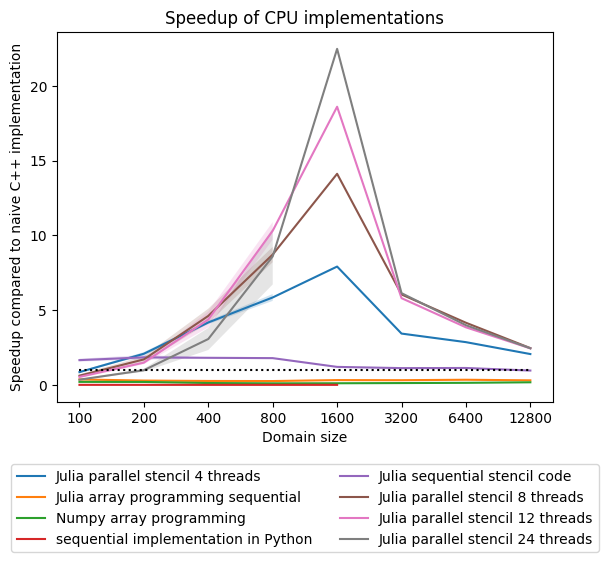

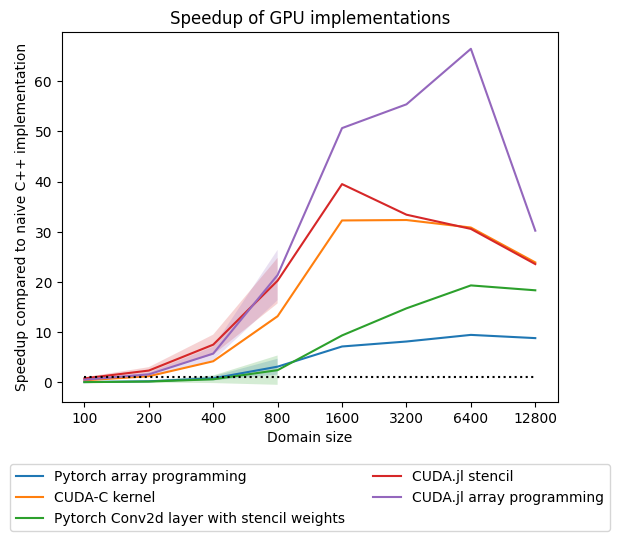

In [18]:
def plot_implementations(implementations, data_dict, category="mean_speedup"):
    max_x = 0
    max_y = 0
    
    for implementation in implementations:
        data = data_dict[implementation][category]
        space = np.linspace(1, data.size, data.size)
        plt.plot(space, data, label=implementations_dict[implementation]["label"])
        plt.fill_between(space, data - data_dict[implementation]["std_speedup"], data + data_dict[implementation]["std_speedup"], alpha=0.2)
        max_x = np.max([max_x, space.size])
        max_y = np.max([max_y, np.max(data)])
        
    plt.xticks(np.linspace(1, 8, 8), grid_sizes)
    plt.xlabel("Domain size")
    plt.ylabel("Speedup compared to naive C++ implementation")
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.plot([1, max_x], [1, 1], c="black", linestyle="dotted")
        
cpu_implementations = ["julia_parallel_stencil", "julia_sequential_array", "numpy_array", "python_lists", "julia_sequential_stencil", "julia_parallel_stencil_8_threads", "julia_parallel_stencil_12_threads", "julia_parallel_stencil_24_threads"]
gpu_implementations = ["pytorch_array", "cpp_cuda_stencil", "pytorch_conv", "julia_cuda_stencil", "julia_cuda_array"]
   
plt.title("Speedup of CPU implementations")     
plot_implementations(cpu_implementations, implementations_dict)
plt.savefig("figures/speedup_cpu_implementations.pdf",bbox_inches='tight')
plt.show()

plt.title("Speedup of GPU implementations")
plot_implementations(gpu_implementations, implementations_dict)
plt.savefig("figures/speedup_gpu_implementations.pdf",bbox_inches='tight')
plt.show()

In [19]:
sp_compute = 2150
dp_compute = sp_compute / 2

plt.loglog(x, y)
plt.xlim([100, 10000])
plt.ylim([100, 10000])

#sp ideal cache
x = [0, 3440, 10000]
y = [0, sp_compute, sp_compute]

#dp ideal cache
x = [0, 3440, 10000]
y = [0, dp_compute, dp_compute]
plt.loglog(x, y)

#sp cache agnostic no full row fits in cache
x = [0, 6880, 10000]
y = [0, sp_compute, sp_compute]
plt.loglog(x, y)

NameError: name 'x' is not defined